In [60]:
# remember to load the environment first by running `conda activate colombia_analysis`
#import all the handy dandy libraries
import os
import glob
import numpy as np
import pandas as pd
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import gridspec
%matplotlib inline

#get useful tools from augur
from augur.utils import json_to_tree
#designating font parameters for later plotting.
font_path = '/usr/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/HelveticaNeue.ttf'
font_properties = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_properties.get_name()
mpl.rcParams['font.weight']=100
mpl.rcParams['axes.labelweight']=100
mpl.rcParams['font.size']=14

In [2]:
def load_tree_from_file_path(json_file_path):
    ''' loads the tree from a json file path, which is just a little more in line with how we think about loading files in python.'''
    with open(json_file_path) as file:
        loaded_json = json.load(file)
        tree = json_to_tree(loaded_json)
    return tree


def count_introductions(node, to_country, transitions=0): #remember to start at the root node for most cases
    """ recursive function that takes in a node, evaluates whether its children represent introductions
        and evaluates the children's children if they are not introductions.
        BY DESIGN THIS FUNCTION DOES NOT TRAVERSE FURTHER DOWN A SUBTREE ONCE AN INTRODUCTION HAS BEEN DETECTED."""
    node_country = node.attr["country"]    
    
    if node.is_terminal(): # child is a leaf
        transitions = transitions
    
    else: #if node is an internal node, and therefore has children
        for child in node.clades:
            child_country = child.attr["country"]
            #child of node is terminal, and is an introduction
            if child.is_terminal() and child_country != node_country and child_country == to_country:
                transitions += 1
            #child of node is terminal, but is not an introduction
            elif child.is_terminal() and child_country != to_country:
                transitions = transitions
            #child is an internal node, but is also an introduction
            elif not child.is_terminal() and child_country != node_country and child_country == to_country: # introduction on internal branch, count and don't recurse.
                transitions += 1
            #otherwise
            else:
                transitions = count_introductions(child, to_country, transitions = transitions)
    return transitions


In [3]:
#JUST TESTING OUT MY FUNCTION, ANSWER SHOULD BE TWO!
with open("../auspice/zika-colombia_tree.json") as file:
    json_tree = json.load(file)
tree = json_to_tree(json_tree)

counter = 0
starting_node = tree.root
print((count_introductions(starting_node, "colombia")))

2


In [80]:
colombia_df = pd.DataFrame({'n_seqs': [], 'trial_number': [], 'introduction_count': []})
for filepath in glob.glob(os.path.join('../supplemental-analysis/rarefaction-curves/colombia/col-replicate-*/auspice/*', '*_tree.json')):
    n_seqs = int(filepath.strip("../supplemental-analysis/rarefaction-curves/colombia/").split('/')[3].split("-")[2])
    trial_number = int(filepath.strip("../supplemental-analysis/rarefaction-curves/colombia/").split('/')[3].split("-")[3].split("_")[0])
    tree = load_tree_from_file_path(filepath)
    start_node = tree.root
    n_introductions = count_introductions(start_node, "colombia")
    colombia_df = colombia_df.append({'n_seqs': n_seqs, 'trial_number': trial_number, 'introduction_count': n_introductions}, ignore_index=True)

In [83]:
mexico_df = pd.DataFrame({'n_seqs': [], 'trial_number': [], 'introduction_count': []})
for filepath in glob.glob(os.path.join('../supplemental-analysis/rarefaction-curves/mexico/mex-replicate-*/auspice/*', '*_tree.json')):
    n_seqs = int(filepath.strip("../supplemental-analysis/rarefaction-curves/mexico/").split('/')[3].split("-")[2])
    trial_number = int(filepath.strip("../supplemental-analysis/rarefaction-curves/mexico/").split('/')[3].split("-")[3].split("_")[0])
    tree = load_tree_from_file_path(filepath)
    start_node = tree.root
    n_introductions = count_introductions(start_node, "mexico")
    mexico_df = mexico_df.append({'n_seqs': n_seqs, 'trial_number': trial_number, 'introduction_count': n_introductions}, ignore_index=True)

In [101]:
#making these dataframes with number of counts of n_introductions_observed, for each degree of subsampling
#I'll use these to scale the size of circles when plotting the data below.
#i.e. show the number of introductions observed for each number of sequences subsampled, where circle size
#encodes the frequency that that number of introductions was observed across the 30 trials.

col_by_trial = colombia_df.groupby(['n_seqs', 'introduction_count'], as_index=False).agg('count')

mex_by_trial = mexico_df.groupby(['n_seqs', 'introduction_count'], as_index=False).agg('count')

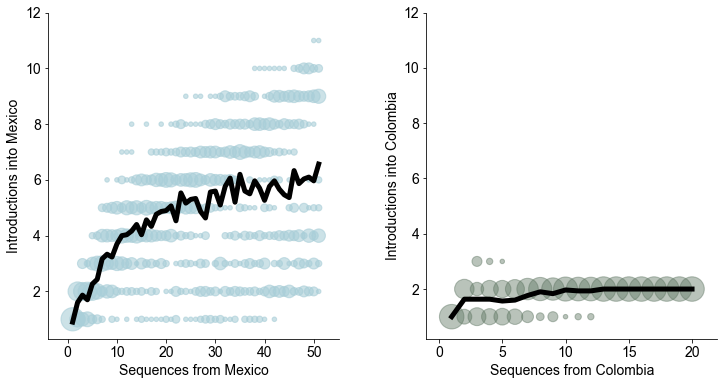

In [126]:
#make the figure
gs = gridspec.GridSpec(1,2, wspace=0.3, hspace=0 )
fig = plt.subplots(figsize=(12,6), facecolor="w")
ax = plt.subplot(gs[0])

for row in mex_by_trial:
    x = mex_by_trial["n_seqs"]
    y = mex_by_trial["introduction_count"]
    circle_size = mex_by_trial["trial_number"] * 20
    plt.scatter(x,y, color="#a9cfd9", s=circle_size, zorder=11, alpha=0.25)

mex_x = [i for i in range(1,52)] #make a list of x-values
means_mex = [] #these will be the y values for the line showing the mean number of introductions
for i in range(1,52):
    values = []
    for j in range(1,31):
        x = i
        y = int(mexico_df.loc[(mexico_df['n_seqs'] == i) & (mexico_df['trial_number'] == j)]["introduction_count"])
        values.append(y)
    means_mex.append(np.mean(values))
plt.plot(mex_x,means_mex, color="black", linewidth=5, zorder=11)

ax.set_ylim(0.3,12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for tick in ax.get_xticklabels():
    tick.set_fontname("arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("arial")

ax.set_xlabel("Sequences from Mexico", fontname = "arial")
ax.set_ylabel("Introductions into Mexico", fontname = "arial")




ax2 = plt.subplot(gs[1])

for row in col_by_trial:
    x = col_by_trial["n_seqs"]
    y = col_by_trial["introduction_count"]
    circle_size = col_by_trial["trial_number"] * 20
    plt.scatter(x,y, color="#637a66", s=circle_size, zorder=11, alpha=0.175)

col_x = [i for i in range(1,21)]
means_col = []
for i in range(1,21):
    values = []
    for j in range(1,31):
        x = i
        y = int(colombia_df.loc[(colombia_df['n_seqs'] == i) & (colombia_df['trial_number'] == j)]["introduction_count"])
        values.append(y)
    means_col.append(np.mean(values))

plt.plot(col_x, means_col, color="black", linewidth=5, zorder=11)
    
ax2.set_ylim(0.2,12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

for tick in ax2.get_xticklabels():
    tick.set_fontname("arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("arial")

ax2.set_xlabel("Sequences from Colombia", fontname = "arial")
ax2.set_ylabel("Introductions into Colombia", fontname = "arial")

plt.savefig("../manuscript/figures/rarefaction_curves.png", dpi=250)